In [1]:
using Gen, Statistics, Memoize, Luxor
import StatsPlots


(process:23988): GLib-GIO-WARNING **: 14:19:22.217: Unexpectedly, UWP app `XBMCFoundation.Kodi_19.0.500.0_x64__4n2hpmxwrvr6p' (AUMId `XBMCFoundation.Kodi_4n2hpmxwrvr6p!Kodi') supports 120 extensions but has no verbs


This chapter explores some key features of MDPs: stochastic dynamics, stochastic policies, and value functions.

### Hiking in Gridworld

We begin by introducing a new gridworld MDP:

> **Hiking Problem**:
>Suppose that Alice is hiking. There are two peaks nearby, denoted "West" and "East". The peaks provide different views and Alice must choose between them. South of Alice's starting position is a steep hill. Falling down the hill would result in painful (but non-fatal) injury and end the hike early.

We represent Alice's hiking problem with a Gridworld similar to Bob's Restaurant Choice example. The peaks are terminal states, providing different utilities. The steep hill is represented by a row of terminal state, each with identical negative utility. Each timestep before Alice reaches a terminal state incurs a "time cost", which is negative to represent the fact that Alice prefers a shorter hike.

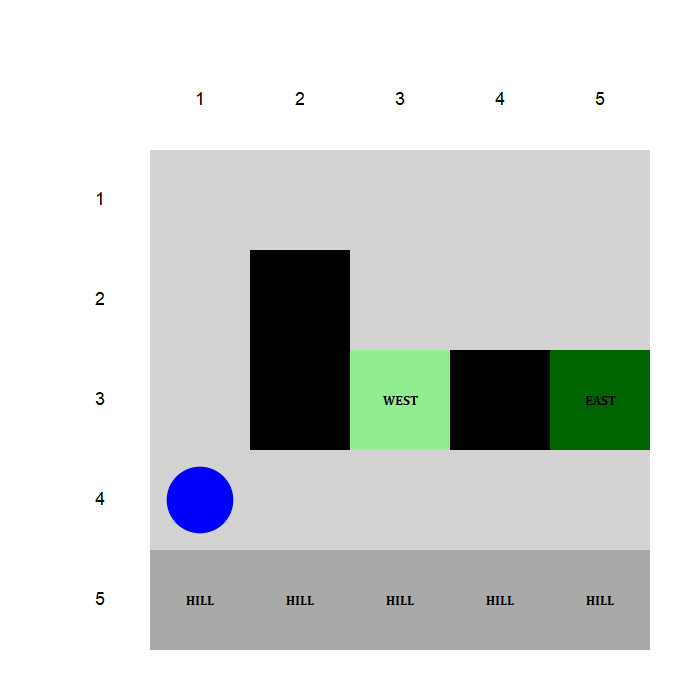

In [2]:
grid_world = [
    "___" "___" "___" "___" "___";
    "___"  "#"  "___" "___" "___";
    "___"  "#"   "W"   "#"   "E" ;
    "___" "___" "___" "___" "___";
    "H"    "H"   "H"   "H"   "H" ;
]

grid_size = size(grid_world)
n_rows, n_cols = grid_size
agent_state = [4,1]

grid_world_colors = Dict(
    "H" => "dark grey",
    "W" => "light green",
    "E" => "dark green", 
    "___"=> "light grey",
    "#" => "black"
)

grid_world_names = Dict(
    "H" => "HILL",
    "W" => "WEST",
    "E" => "EAST", 
    "___"=> "",
    "#" => ""
)

function get_state(n)
    row = (n-1) ÷ (grid_size[2] + 1)
    col = (n-1) % (grid_size[2] + 1)
    return [row, col]
end

function get_tile(state)
    return grid_world[state...]
end

Drawing((n_cols + 2) * 100, (n_rows + 2) * 100 , :png)
origin()
background("white")

tiles = Tiler((n_cols + 1) * 100, (n_rows + 1) * 100, n_rows + 1,n_cols + 1, margin=0)
for (pos, n) in tiles
    state = get_state(n)
    if state[1] == 0 || state[2] == 0
        if state != [0,0]
            fontsize(18)
            fontface("")
            sethue("black")
            textcentered(string(max(state...)), pos + Point(0, 5))
        end
        continue
    end
    tile = get_tile(state)
    sethue(grid_world_colors[tile])
    box(pos, tiles.tilewidth, tiles.tileheight, :fill)
    fontsize(13)
    fontface("Cambria Bold")
    sethue("black")
    textcentered(grid_world_names[tile], pos + Point(0, 5))
    if (state == agent_state)
        sethue("blue")
        circle(pos, min(tiles.tilewidth, tiles.tileheight) / 3, :fill)
    end
end

finish()
preview()

We start with a *deterministic* transition function. In this case, Alice's risk of falling down the steep hill is solely due to softmax noise in her action choice (which is minimal in this case). The agent model is the same as the one at the end of Chapter III.1. We place the functions `act`, `expectedUtility` in a function `makeMDPAgent`. The following codebox defines this function and we use it later on without defining it (since it's in the `webppl-agents` library).

In [3]:
CONTROL_FACTOR = 50
AMOUNT = 1000

actions = [:up,:down,:left,:right]
grid_world = [
    "___" "___" "___" "___" "___";
    "___"  "#"  "___" "___" "___";
    "___"  "#"   "W"   "#"   "E" ;
    "___" "___" "___" "___" "___";
    "H"    "H"   "H"   "H"   "H" ;
]

grid_size = size(grid_world)
n_rows, n_cols = grid_size

grid_world_utilities = Dict(
  "E" => 10,
  "W" => 1,
  "H" => -10,
  "___"=> -0.1
)
n_rows, n_cols = size(grid_world)
grid_size = (n_rows, n_cols)

start_state = [4,1]

function transition(state,action)
    if action == :down && state[1] < grid_size[1] && get_tile([state[1]+1,state[2]]) != "#"
        return [state[1]+1,state[2]]
    elseif action == :up && state[1] > 1 && get_tile([state[1]-1,state[2]]) != "#"
        return [state[1]-1, state[2]]
    elseif action == :left && state[2] > 1 && get_tile([state[1],state[2]-1]) != "#"
        return [state[1], state[2]-1]
    elseif action == :right && state[2] < grid_size[2] && get_tile([state[1],state[2]+1]) != "#"
        return [state[1], state[2]+1]
    end
    return [state[1],state[2]]
end

function get_tile(state)
    return grid_world[state...]
end

function utility(state)
    return grid_world_utilities[get_tile(state)]
end

function is_terminal_state(state)
    tile = get_tile(state)
    return tile == "E" || tile == "W" || tile == "H"
end

function make_mdp_agent()
    @gen function act(state, time_left)
        action_index = @trace(uniform_discrete(1,length(actions)),:action_index)
        next_action = actions[action_index]
        eu = expected_utility(state, next_action, time_left)
        @trace(bernoulli(exp(CONTROL_FACTOR * eu)), :factor)
        return action_index
    end

    @memoize Dict function run_act(state, time_left)
        action_indices = []
        trace, = generate(act, (state, time_left), choicemap((:factor,1)))
        for i = 1:AMOUNT
            trace, = Gen.mh(trace, select(:action_index))
            push!(action_indices, get_retval(trace))
        end
        return action_indices
    end

    @gen function reward(state, action, time_left)
        next_state = transition(state, action)
        action_indices = run_act(next_state, time_left)
        rand_choice = @trace(uniform_discrete(1, length(action_indices)), :rand_choice)
        next_action_idx = action_indices[rand_choice]
        next_action = actions[next_action_idx]
        return expected_utility(next_state, next_action, time_left)
    end

    @memoize Dict function run_reward(state, action, time_left)
        rewards = []
        trace, = generate(reward, (state, action, time_left))
        for i =1:AMOUNT
            trace, = Gen.mh(trace, select(:rand_choice))
            push!(rewards, get_retval(trace))
        end
        return rewards
    end

    @memoize Dict function expected_utility(state, action, time_left)
        u = utility(state)
        new_time_left = time_left - 1
        if is_terminal_state(state) || new_time_left == 0
            return u
        else
            return u + mean(run_reward(state, action, new_time_left))
        end
    end
    return run_act
end

function simulate_agent(start_state, total_time)
    states = []
    run_act = make_mdp_agent()
    next_state = start_state
    while !is_terminal_state(next_state) && total_time > 0
        push!(states, next_state)
        action_indices = run_act(next_state, total_time)
        rand_choice = uniform_discrete(1, length(action_indices))
        next_action_idx = action_indices[rand_choice]
        next_action = actions[next_action_idx]
        next_state = transition(next_state, next_action)
        total_time -= 1
    end
    push!(states, next_state)
    return states
end;

┌ Info: Frames for animation "agent trajectory" are being stored in directory: 
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_rhC93Q
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:178
┌ Info: ... 6 frames saved in directory:
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_rhC93Q
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:200
┌ Info: GIF is: C:\Users\omrif\AppData\Local\Temp\jl_rhC93Q/agent trajectory.gif
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:229


Luxor.AnimatedGif("C:\\Users\\omrif\\AppData\\Local\\Temp\\jl_rhC93Q/agent trajectory.gif")
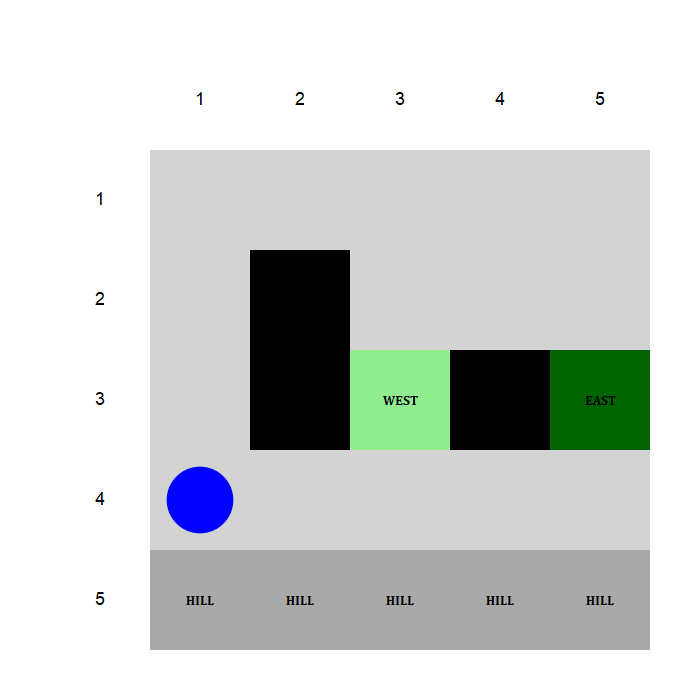

In [4]:
traj = simulate_agent(start_state, 20)

grid_world_colors = Dict(
    "H" => "dark grey",
    "W" => "light green",
    "E" => "dark green", 
    "___"=> "light grey",
    "#" => "black"
)

grid_world_names = Dict(
    "H" => "HILL",
    "W" => "WEST",
    "E" => "EAST", 
    "___"=> "",
    "#" => ""
)

function get_state(n)
    row = (n-1) ÷ (grid_size[2] + 1)
    col = (n-1) % (grid_size[2] + 1)
    return [row, col]
end

demo = Movie((n_cols + 2) * 100, (n_rows + 2) * 100, "agent trajectory", 1:length(traj))
function backdrop(scene, framenumber)
    background("white")
end

function frame(scene, framenumber)
    tiles = Tiler((n_cols + 1) * 100, (n_rows + 1) * 100, n_rows + 1,n_cols + 1, margin=0)
    agent_state = traj[framenumber]
    for (pos, n) in tiles
        state = get_state(n)
        if state[1] == 0 || state[2] == 0
            if state != [0,0]
                fontsize(18)
                fontface("")
                sethue("black")
                textcentered(string(max(state...)), pos + Point(0, 5))
            end
            continue
        end
        tile = get_tile(state)
        sethue(grid_world_colors[tile])
        box(pos, tiles.tilewidth, tiles.tileheight, :fill)
        fontsize(13)
        fontface("Cambria Bold")
        sethue("black")
        textcentered(grid_world_names[tile], pos + Point(0, 5))
        if (state == agent_state)
            sethue("blue")
            circle(pos, min(tiles.tilewidth, tiles.tileheight) / 3, :fill)
        end
    end
end

animate(demo, [
    Scene(demo, backdrop),
    Scene(demo, frame)
    ],
    framerate=5,
    creategif=true)

>**Exercise**: Adjust the parameters of `utilityTable` in order to produce the following behaviors:

>1. The agent goes directly to "West".
>2. The agent takes the long way around to "West".
>3. The agent sometimes goes to the Hill at $[1,0]$. Try to make this outcome as likely as possible.
<!-- 3 is obtained by making timeCost positive and Hill better than alternatives -->


### Hiking with stochastic transitions

Imagine that the weather is very wet and windy. As a result, Alice will sometimes intend to go one way but actually go another way (because she slips in the mud). In this case, the shorter route to the peaks might be too risky for Alice.

To model bad weather, we assume that at every timestep, there is a constant independent probability `transitionNoiseProbability` of the agent moving orthogonally to their intended direction. The independence assumption is unrealistic (if a location is slippery at one timestep it is more likely slippery the next), but it is simple and satisfies the Markov assumption for MDPs.

Setting `transitionNoiseProbability=0.1`, the agent's first action is now to move "up" instead of "right".

In [5]:
CONTROL_FACTOR = 50
AMOUNT = 1000
NOISE = 0.1
TRAJECTORIES_AMOUNT = 50

actions = [:up,:down,:left,:right]
grid_world = [
    "___" "___" "___" "___" "___";
    "___"  "#"  "___" "___" "___";
    "___"  "#"   "W"   "#"   "E" ;
    "___" "___" "___" "___" "___";
    "H"    "H"   "H"   "H"   "H" ;
]

grid_size = size(grid_world)
n_rows, n_cols = grid_size

grid_world_utilities = Dict(
  "E" => 10,
  "W" => 1,
  "H" => -10,
  "___"=> -0.1
)
n_rows, n_cols = size(grid_world)
grid_size = (n_rows, n_cols)

start_state = [4,1]

function execute_action(state,action)
    if action == :down && state[1] < grid_size[1] && get_tile([state[1]+1,state[2]]) != "#"
        return [state[1]+1,state[2]]
    elseif action == :up && state[1] > 1 && get_tile([state[1]-1,state[2]]) != "#"
        return [state[1]-1, state[2]]
    elseif action == :left && state[2] > 1 && get_tile([state[1],state[2]-1]) != "#"
        return [state[1], state[2]-1]
    elseif action == :right && state[2] < grid_size[2] && get_tile([state[1],state[2]+1]) != "#"
        return [state[1], state[2]+1]
    end
    return [state[1],state[2]]
end
function transition(state,action)
    is_noise = bernoulli(NOISE)
    if is_noise
        if action == :up || action == :down
            is_right = bernoulli(0.5)
            if is_right
                action = :right
            else
                action = :left
            end
        elseif action == :right || action == :left
            is_up = bernoulli(0.5)
            if is_up
                action = :up
            else
                action = :down
            end
        end
    end
    return execute_action(state,action)
    
end
function get_tile(state)
    return grid_world[state...]
end

function utility(state)
    return grid_world_utilities[get_tile(state)]
end

function is_terminal_state(state)
    tile = get_tile(state)
    return tile == "E" || tile == "W" || tile == "H"
end

function make_mdp_agent()
    @gen function act(state, time_left)
        action_index = @trace(uniform_discrete(1,length(actions)),:action_index)
        next_action = actions[action_index]
        eu = expected_utility(state, next_action, time_left)
        @trace(bernoulli(exp(CONTROL_FACTOR * eu)), :factor)
        return action_index
    end

    @memoize Dict function run_act(state, time_left)
        action_indices = []
        trace, = generate(act, (state, time_left), choicemap((:factor,1)))
        for i = 1:AMOUNT
            trace, = Gen.mh(trace, select(:action_index))
            push!(action_indices, get_retval(trace))
        end
        return action_indices
    end

    @gen function reward(state, action, time_left)
        next_state = transition(state, action)
        action_indices = run_act(next_state, time_left)
        rand_choice = @trace(uniform_discrete(1, length(action_indices)), :rand_choice)
        next_action_idx = action_indices[rand_choice]
        next_action = actions[next_action_idx]
        return expected_utility(next_state, next_action, time_left)
    end

    @memoize Dict function run_reward(state, action, time_left)
        rewards = []
        trace, = generate(reward, (state, action, time_left))
        for i =1:AMOUNT
            trace, = Gen.mh(trace, select(:rand_choice))
            push!(rewards, get_retval(trace))
        end
        return rewards
    end

    @memoize Dict function expected_utility(state, action, time_left)
        u = utility(state)
        new_time_left = time_left - 1
        if is_terminal_state(state) || new_time_left == 0
            return u
        else
            return u + mean(run_reward(state, action, new_time_left))
        end
    end
    return run_act
end

function simulate_agent(start_state, total_time)
    states = []
    run_act = make_mdp_agent()
    next_state = start_state
    while !is_terminal_state(next_state) && total_time > 0
        push!(states, next_state)
        action_indices = run_act(next_state, total_time)
        rand_choice = uniform_discrete(1, length(action_indices))
        next_action_idx = action_indices[rand_choice]
        next_action = actions[next_action_idx]
        next_state = transition(next_state, next_action)
        total_time -= 1
    end
    push!(states, next_state)
    return states
end;


┌ Info: Frames for animation "agent trajectory" are being stored in directory: 
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_nHQuSC
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:178
┌ Info: ... 10 frames saved in directory:
│ 	 C:\Users\omrif\AppData\Local\Temp\jl_nHQuSC
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:200
┌ Info: GIF is: C:\Users\omrif\AppData\Local\Temp\jl_nHQuSC/agent trajectory.gif
└ @ Luxor C:\Users\omrif\.julia\packages\Luxor\XHa4Y\src\animate.jl:229


Luxor.AnimatedGif("C:\\Users\\omrif\\AppData\\Local\\Temp\\jl_nHQuSC/agent trajectory.gif")
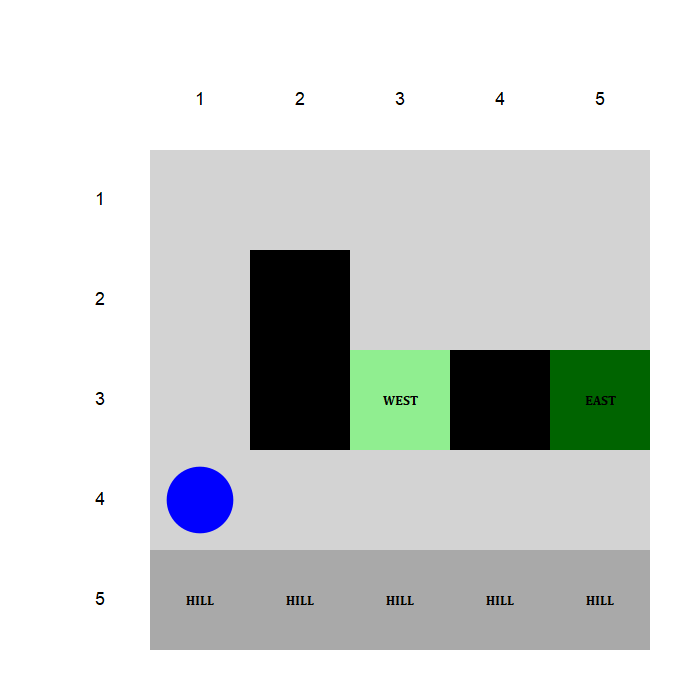

In [6]:
traj = simulate_agent(start_state, 20)

grid_world_colors = Dict(
    "H" => "dark grey",
    "W" => "light green",
    "E" => "dark green", 
    "___"=> "light grey",
    "#" => "black"
)

grid_world_names = Dict(
    "H" => "HILL",
    "W" => "WEST",
    "E" => "EAST", 
    "___"=> "",
    "#" => ""
)

function get_state(n)
    row = (n-1) ÷ (grid_size[2] + 1)
    col = (n-1) % (grid_size[2] + 1)
    return [row, col]
end

demo = Movie((n_cols + 2) * 100, (n_rows + 2) * 100, "agent trajectory", 1:length(traj))
function backdrop(scene, framenumber)
    background("white")
end

function frame(scene, framenumber)
    tiles = Tiler((n_cols + 1) * 100, (n_rows + 1) * 100, n_rows + 1,n_cols + 1, margin=0)
    agent_state = traj[framenumber]
    for (pos, n) in tiles
        state = get_state(n)
        if state[1] == 0 || state[2] == 0
            if state != [0,0]
                fontsize(18)
                fontface("")
                sethue("black")
                textcentered(string(max(state...)), pos + Point(0, 5))
            end
            continue
        end
        tile = get_tile(state)
        sethue(grid_world_colors[tile])
        box(pos, tiles.tilewidth, tiles.tileheight, :fill)
        fontsize(13)
        fontface("Cambria Bold")
        sethue("black")
        textcentered(grid_world_names[tile], pos + Point(0, 5))
        if (state == agent_state)
            sethue("blue")
            circle(pos, min(tiles.tilewidth, tiles.tileheight) / 3, :fill)
        end
    end
end

animate(demo, [
    Scene(demo, backdrop),
    Scene(demo, frame)
    ],
    framerate=5,
    creategif=true)

In [11]:
@memoize Dict function get_trajectory_length_dict()
    length_dict = Dict()
    for i=1:TRAJECTORIES_AMOUNT
        traj_length = string(length(simulate_agent(start_state,13)))
        if haskey(length_dict,traj_length)
            length_dict[traj_length]+=1
        else
            length_dict[traj_length]=1
        end
    end
    return length_dict
end
dict = get_trajectory_length_dict()
print(dict)


Dict{Any, Any}("16" => 1, "12" => 11, "10" => 18, "11" => 11, "9" => 1, "13" => 7, "14" => 1)

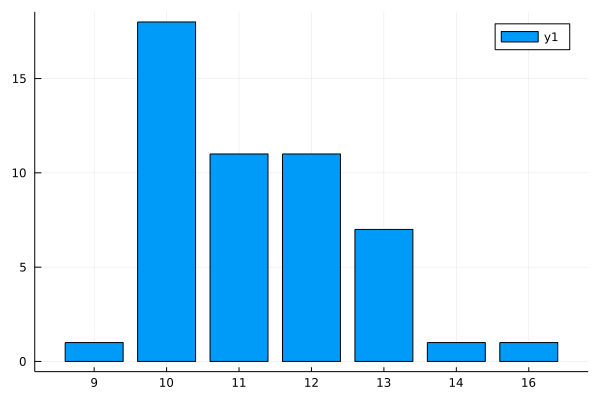

In [27]:
vector_tuples = sort(collect(dict), by = x->parse(Int64,x[1]))
StatsPlots.bar(map(tup -> tup[1],vector_tuples),map(tup -> tup[2],vector_tuples))

>**Exercise:**

>1. Keeping `transitionNoiseProbability=0.1`, find settings for `utilityTable` such that the agent goes "right" instead of "up".
>2. Set `transitionNoiseProbability=0.01`. Change a single parameter in `utilityTable` such that the agent goes "right" (there are multiple ways to do this).
<!-- put up timeCost to -1 or so -->

### Noisy transitions vs. Noisy agents

It's important to distinguish noise in the transition function from the softmax noise in the agent's selection of actions. Noise (or "stochasticity") in the transition function is a representation of randomness in the world. This is easiest to think about in games of chance[^noise]. In a game of chance (e.g. slot machines or poker) rational agents will take into account the randomness in the game. By contrast, softmax noise is a property of an agent. For example, we can vary the behavior of otherwise identical agents by varying their parameter $\alpha$.

Unlike transition noise, softmax noise has little influence on the agent's planning for the Hiking Problem. Since it's so bad to fall down the hill, the softmax agent will rarely do so even if they take the short route. The softmax agent is like a person who takes inefficient routes when stakes are low but "pulls themself together" when stakes are high.

>**Exercise:** Use the codebox below to explore different levels of softmax noise. Find a setting of `utilityTable` and `alpha` such that the agent goes to West and East equally often and nearly always takes the most direct route to both East and West. Included below is code for simulating many trajectories and returning the trajectory length. You can extend this code to measure whether the route taken by the agent is direct or not. (Note that while the softmax agent here is able to "backtrack" or return to its previous location, in later Gridworld examples we disalllow backtracking as a possible action).

~~~~javascript
///fold: makeHikeMDP, set up world
var makeHikeMDP = function(options) {
  var H = { name: 'Hill' };
  var W = { name: 'West' };
  var E = { name: 'East' };
  var ___ = ' ';
  var grid = [
    [___, ___, ___, ___, ___],
    [___, '#', ___, ___, ___],
    [___, '#',  W , '#',  E ],
    [___, ___, ___, ___, ___],
    [ H ,  H ,  H ,  H ,  H ]
  ];
  return makeGridWorldMDP(_.assign({ grid }, options));
};

var mdp = makeHikeMDP({
  start: [0, 1],
  totalTime: 13,
  transitionNoiseProbability: 0.1
});

var world = mdp.world;
var startState = mdp.startState;
var makeUtilityFunction = mdp.makeUtilityFunction;
///

// Create parameterized agent
var utility = makeUtilityFunction({
  East: 10,
  West: 1,
  Hill: -10,
  timeCost: -.1
});
var alpha = 1;  // <- SOFTMAX NOISE
var agent = makeMDPAgent({ utility, alpha }, world);

// Generate a single trajectory, draw
var trajectory = simulateMDP(startState, world, agent, 'states');
viz.gridworld(world, { trajectory });

// Generate 100 trajectories, plot distribution on lengths
var trajectoryDist = Infer({
  model() {
    var trajectory = simulateMDP(startState, world, agent);
    return { trajectoryLength: trajectory.length }
  },
  method: 'forward',
  samples: 100
});
viz(trajectoryDist);
~~~~

In [8]:
#TODO: write Julia and Gen code for the code above

### Stochastic transitions: plans and policies

We return to the case of a stochastic environment with very low softmax action noise. In a stochastic environment, the agent sometimes finds themself in a state they did not intend to reach. The functions `agent` and `expectedUtility` (inside `makeMDPAgent`) implicitly compute the expected utility of actions for every possible future state, including states that the agent will try to avoid. In the MDP literature, this function from states and remaining time to actions is called a *policy*. (For infinite-horizon MDPs, policies are functions from states to actions.) Since policies take into account every possible contingency, they are quite different from the everyday notion of a plan.

Consider the example from above where the agent takes the long route because of the risk of falling down the hill. If we generate a single trajectory for the agent, they will likely take the long route. However, if we generated many trajectories, we would sometimes see the agent move "right" instead of "up" on their first move. Before taking this first action, the agent implicitly computes what they *would* do if they end up moving right. To find out what they would do, we can artificially start the agent in $[1,1]$ instead of $[0,1]$:

<!-- policy -->
~~~~javascript
///fold: makeHikeMDP
var makeHikeMDP = function(options) {
  var H = { name: 'Hill' };
  var W = { name: 'West' };
  var E = { name: 'East' };
  var ___ = ' ';
  var grid = [
    [___, ___, ___, ___, ___],
    [___, '#', ___, ___, ___],
    [___, '#',  W , '#',  E ],
    [___, ___, ___, ___, ___],
    [ H ,  H ,  H ,  H ,  H ]
  ];
  return makeGridWorldMDP(_.assign({ grid }, options));
};
///

// Parameters for world
var mdp = makeHikeMDP({
  start: [1, 1],  // Previously: [0, 1]
  totalTime: 11,  // Previously: 12
  transitionNoiseProbability: 0.1
});
var makeUtilityFunction = mdp.makeUtilityFunction;

// Parameters for agent
var utility = makeUtilityFunction({ 
  East: 10, 
  West: 1,
  Hill: -10,
  timeCost: -.1
});
var agent = makeMDPAgent({ utility, alpha: 1000 }, mdp.world);
var trajectory = simulateMDP(mdp.startState, mdp.world, agent, 'states');

viz.gridworld(mdp.world, { trajectory });
~~~~

In [9]:
#TODO: write Julia and Gen code for the code above

Extending this idea, we can display the expected values of each action the agent *could have taken* during their trajectory. These expected values numbers are analogous to state-action Q-values in infinite-horizon MDPs.

The expected values were already being computed implicitly; we now use `getExpectedUtilitiesMDP` to access them. The displayed numbers in each grid cell are the expected utilities of moving in the corresponding directions. For example, we can read off how close the agent was to taking the short route as opposed to the long route. (Note that if the difference in expected utility between two actions is small then a noisy agent will take each of them with nearly equal probability).

~~~~javascript
///fold: makeBigHikeMDP, getExpectedUtilitiesMDP
var makeBigHikeMDP = function(options) {
  var H = { name: 'Hill' };
  var W = { name: 'West' };
  var E = { name: 'East' };
  var ___ = ' ';
  var grid = [
    [___, ___, ___, ___, ___, ___],
    [___, ___, ___, ___, ___, ___],
    [___, ___, '#', ___, ___, ___],
    [___, ___, '#',  W , '#',  E ],
    [___, ___, ___, ___, ___, ___],
    [ H ,  H ,  H ,  H ,  H ,  H ]
  ];
  return makeGridWorldMDP(_.assign({ grid }, options));
};

// trajectory must consist only of states. This can be done by calling
// *simulate* with an additional final argument 'states'.
var getExpectedUtilitiesMDP = function(stateTrajectory, world, agent) {
  var eu = agent.expectedUtility;
  var actions = world.actions;
  var getAllExpectedUtilities = function(state) {
    var actionUtilities = map(
      function(action){ return eu(state, action); },
      actions);
    return [state, actionUtilities];
  };
  return map(getAllExpectedUtilities, stateTrajectory);
};
///

// Long route is better, agent takes long route

var mdp = makeBigHikeMDP({
  start: [1, 1],
  totalTime: 12,
  transitionNoiseProbability: 0.03
});
var makeUtilityFunction = mdp.makeUtilityFunction;

var utility = makeUtilityFunction({
  East: 10,
  West: 7,
  Hill : -40,
  timeCost: -0.4
});
var agent = makeMDPAgent({ utility, alpha: 100 }, mdp.world);

var trajectory = simulateMDP(mdp.startState, mdp.world, agent, 'states');
var actionExpectedUtilities = getExpectedUtilitiesMDP(trajectory, mdp.world, agent);

viz.gridworld(mdp.world, { trajectory, actionExpectedUtilities });
~~~~

In [10]:
#TODO: write Julia and Gen code for the code above

So far, our agents all have complete knowledge about the state of the world. In the next chapter, we will explore partially observable worlds.

<br>

### Footnotes

[^noise]: An agent's world model might treat a complex set of deterministic rules as random. In this sense, agents will vary in whether they represent an MDP as stochastic or not. We won't consider that case in this tutorial.